## Este notebook es encargado de implementar un modelo para realizar la predicción del estado emocional de una sesión de prueba

In [36]:
import pickle
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np

In [37]:
model = pickle.load(open('./models/model', 'rb'))
# result_val = model.score(xval, yval)
# result_test = model.score(xtest, ytest)

In [38]:
df_1 = pd.read_csv("..//resources//csv//data//sujeto1-rocio-2020-10-25-biometrics.csv")
df_2 = pd.read_csv("..//resources//csv//data//sujeto2-juan-2020-11-01-biometrics.csv")
df_3 = pd.read_csv("..//resources//csv//data//sujeto3-brenda-2020-11-16-biometrics.csv")
df_4 = pd.read_csv("..//resources//csv//data//sujeto4-matias-2020-11-16-biometrics.csv")
df_5 = pd.read_csv("..//resources//csv//data//sujeto5-sebastian-2021-01-05-biometrics.csv")
df_6 = pd.read_csv("..//resources//csv//data//sujeto6-rocio-2021-01-07-biometrics.csv")

df_valence = pd.read_csv("..//resources//csv//data//sujeto6-rocio-2021-01-07-biometrics-valence.csv")

df_to_predict = df_valence

df_to_predict.head()

,TimeStamp,HR,RR,HRV,MicroSiemens,SCR,SCR_MIN,ArousalMean,ValenceMean,ArousalSD,ValenceSD,PhaseName,MatchesSam,HasValence,Valence,ImageName
0,2021-01-07 19:44:40,81.7,734,0.10,1.12,0,0,0.0,0.0,0.0,0.0,NaN,False,0,0.5,NaN
1,2021-01-07 19:44:41,86.2,696,0.00,1.13,0,0,0.0,0.0,0.0,0.0,NaN,False,0,0.5,NaN
2,2021-01-07 19:44:42,82.8,725,0.00,1.12,0,0,0.0,0.0,0.0,0.0,NaN,False,0,0.5,NaN
3,2021-01-07 19:44:43,82.5,727,0.00,1.12,0,0,0.0,0.0,0.0,0.0,NaN,False,0,0.5,NaN
4,2021-01-07 19:44:43,81.9,733,1.05,1.11,0,0,0.0,0.0,0.0,0.0,NaN,False,0,0.5,NaN


In [39]:
def add_prev_values(df, col):
    df.loc[0, f'{col}-4'] = df.loc[0, col]
    df.loc[0, f'{col}-3'] = df.loc[0, col]
    df.loc[0, f'{col}-2'] = df.loc[0, col]
    df.loc[0, f'{col}-1'] = df.loc[0, col]

    for i in range(0, len(df)):
        if i >= 4:
            df.loc[i, f'{col}-4'] = df.loc[i-4, col]
            df.loc[i, f'{col}-3'] = df.loc[i-3, col]
            df.loc[i, f'{col}-2'] = df.loc[i-2, col]
            df.loc[i, f'{col}-1'] = df.loc[i-1, col]
        else:
            df.loc[i, f'{col}-4'] = df.loc[i, col]
            df.loc[i, f'{col}-3'] = df.loc[i, col]
            df.loc[i, f'{col}-2'] = df.loc[i, col]
            df.loc[i, f'{col}-1'] = df.loc[i, col]

In [40]:
# Función que determina cuando un sujeto se encuentra en un estado de excitación (1) o relajación (0) dado un valor de arousal.
def isAroused(arousal):
    return 0 if arousal < 5 else 1

In [41]:
df_to_standarize = df_to_predict.copy()
    
# Se remueven las mediciones sin estímulo (previas al inicio de estímulos), para no ofuscar el entrenamiento
filterNoArousalMeasurements = df_to_standarize['ArousalMean'] > 0
df_to_standarize = df_to_standarize[filterNoArousalMeasurements]

# remover las mediciones para las que el sam no coincidió antes de la estandarización, para no afectar la desviación
# filterNoMatchesSAMMeasurements = filtered1['MatchesSam'] == True
# df_to_standarize = df_to_standarize[filterNoMatchesSAMMeasurements]

# Se agrega la columna Aroused (0/1) para la clasificación binaria
df_to_standarize['Aroused'] = df_to_standarize['ArousalMean'].map(isAroused)

columns_to_standarize = ['HR', 'RR', 'HRV', 'MicroSiemens']
other_columns = ['SCR', 'SCR_MIN', 'PhaseName', 'ArousalMean', 'Aroused', 'TimeStamp', 'HasValence', 'Valence', 'ImageName']
all_columns = columns_to_standarize + other_columns

scaler = preprocessing.StandardScaler()
standarized_df = scaler.fit_transform(df_to_standarize[columns_to_standarize])

standarized_df_with_rest_of_data = np.append(standarized_df, df_to_standarize[other_columns], axis=1)

# Se convierte a DataFrame
standarized_df_with_rest_of_data = pd.DataFrame(standarized_df_with_rest_of_data, columns=all_columns)

# Se agregan valores imperceptibles de valencia al primer y último registro para poder graficarlo y mantener la escala
standarized_df_with_rest_of_data['HasValence'][0] = 1
standarized_df_with_rest_of_data['Valence'][0] = 0.0001
standarized_df_with_rest_of_data['ImageName'][0] = ''
last_row_index = len(standarized_df_with_rest_of_data) - 1
standarized_df_with_rest_of_data['HasValence'][last_row_index] = 1
standarized_df_with_rest_of_data['Valence'][last_row_index] = 0.0001
standarized_df_with_rest_of_data['ImageName'][last_row_index] = ''

# Conversión de tipos
standarized_df_with_rest_of_data['HR'] = standarized_df_with_rest_of_data['HR'].astype(float)
standarized_df_with_rest_of_data['RR'] = standarized_df_with_rest_of_data['RR'].astype(float)
standarized_df_with_rest_of_data['HRV'] = standarized_df_with_rest_of_data['HRV'].astype(float)
standarized_df_with_rest_of_data['MicroSiemens'] = standarized_df_with_rest_of_data['MicroSiemens'].astype(float)
standarized_df_with_rest_of_data['SCR'] = standarized_df_with_rest_of_data['SCR'].astype(int)
standarized_df_with_rest_of_data['SCR_MIN'] = standarized_df_with_rest_of_data['SCR_MIN'].astype(int)
standarized_df_with_rest_of_data['PhaseName'] = standarized_df_with_rest_of_data['PhaseName']
standarized_df_with_rest_of_data['ArousalMean'] = standarized_df_with_rest_of_data['ArousalMean'].astype(float)
standarized_df_with_rest_of_data['Aroused'] = standarized_df_with_rest_of_data['Aroused'].astype(int)
standarized_df_with_rest_of_data['Aroused'] = standarized_df_with_rest_of_data['Aroused'].astype(int)
standarized_df_with_rest_of_data['TimeStamp'] = standarized_df_with_rest_of_data['TimeStamp']
standarized_df_with_rest_of_data['HasValence'] = standarized_df_with_rest_of_data['HasValence'].astype(int)
standarized_df_with_rest_of_data['Valence'] = standarized_df_with_rest_of_data['Valence'].astype(float)
standarized_df_with_rest_of_data['ImageName'] = standarized_df_with_rest_of_data['ImageName']

# Se agregan a cada columna del dataset las X mediciones anteriores en el tiempo para cada una de las siguientes features.
add_prev_values(standarized_df_with_rest_of_data, "HR")
add_prev_values(standarized_df_with_rest_of_data, "HRV")
add_prev_values(standarized_df_with_rest_of_data, "MicroSiemens")

df_to_predict = standarized_df_with_rest_of_data

In [42]:
y_pred = model.predict(df_to_predict[['MicroSiemens', 'HR', 'HRV', 'MicroSiemens-4', 'MicroSiemens-3', 'MicroSiemens-2', 'MicroSiemens-1', 'HR-4', 'HR-3', 'HR-2', 'HR-1', 'HRV-4','HRV-3','HRV-2','HRV-1']].values)

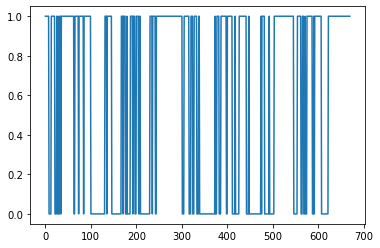

In [43]:
plt.plot(y_pred)
plt.show()

In [44]:
model.score(df_to_predict[['MicroSiemens', 'HR', 'HRV', 'MicroSiemens-4', 'MicroSiemens-3', 'MicroSiemens-2', 'MicroSiemens-1', 'HR-4', 'HR-3', 'HR-2', 'HR-1', 'HRV-4','HRV-3','HRV-2','HRV-1']], df_to_predict[['Aroused']])

0.6567164179104478

In [45]:
df_to_predict['ArousalPred'] = y_pred

df_to_predict.to_csv(r'./3_prediction.csv', date_format='%s', index = False)